In [1]:
#Python-related imports
from datetime import datetime
import os.path

#PyData imports
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

#Torch-related imports
import torch
import torch.distributions as D
import torch.nn.functional as F
import torch.optim as optim
from scipy.optimize import bisect
from torch.autograd import Function

In [2]:
# Hack to import from a parent directory
import sys
path = '..'
if path not in sys.path:
    sys.path.append(path)
    
from LogitNormal import *

In [3]:
torch.manual_seed(2)
np.random.seed(2)

torch.set_printoptions(precision = 8)

In [4]:
def find_scale(scale, loc, a, b, target_sd):
    x = RescaledLogitNormal(loc, scale, a, b)
    #print(scale, x.mean, x.stddev)
    #print(x.stddev - target_sd)
    return x.stddev - target_sd

In [5]:
SCON_C_priors_details = {k: v for k, v in torch.load(os.path.join('generated_data/', 'SCON-C_CO2_logit_short_2022_01_20_08_53_sample_y_t_5000_dt_0-01_sd_scale_0-25_hyperparams.pt')).items()}
print(SCON_C_priors_details)
stochastic_parameters = ['c_SOC', 'c_DOC', 'c_MBC']
SCON_C_priors_details = dict([(k, v) for k, v in SCON_C_priors_details.items() if k not in stochastic_parameters])
print(SCON_C_priors_details)

keys = list(SCON_C_priors_details.keys())

prior_list = list(zip(*(SCON_C_priors_details[k] for k in list(SCON_C_priors_details.keys()))))
prior_means_tensor, prior_sds_tensor, prior_lowers_tensor, prior_uppers_tensor = torch.tensor(prior_list)
p_theta = RescaledLogitNormal(loc = prior_means_tensor, scale = prior_sds_tensor, a = prior_lowers_tensor, b = prior_uppers_tensor)

lower = prior_lowers_tensor
upper = prior_uppers_tensor

{'u_M': tensor([-4.11903715,  0.24392651,  0.00000000,  0.10000000]), 'a_SD': tensor([0.00000000, 0.53270835, 0.00000000, 1.00000000]), 'a_DS': tensor([0.00000000, 0.53270835, 0.00000000, 1.00000000]), 'a_M': tensor([0.00000000, 0.53270835, 0.00000000, 1.00000000]), 'a_MSC': tensor([0.00000000, 0.53270835, 0.00000000, 1.00000000]), 'k_S_ref': tensor([-5.29330492,  0.24083884,  0.00000000,  0.10000000]), 'k_D_ref': tensor([-4.82028151,  0.24167331,  0.00000000,  0.10000000]), 'k_M_ref': tensor([-4.95482063,  0.24139430,  0.00000000,  0.10000000]), 'Ea_S': tensor([-1.38629436,  0.41090775,  5.00000000, 80.00000000]), 'Ea_D': tensor([-1.38629436,  0.41090775,  5.00000000, 80.00000000]), 'Ea_M': tensor([-1.38629436,  0.41090775,  5.00000000, 80.00000000]), 'c_SOC': tensor([-2.19722462,  0.27027950,  0.00000000,  0.10000000]), 'c_DOC': tensor([-3.89182019,  0.24506786,  0.00000000,  0.10000000]), 'c_MBC': tensor([-3.89182019,  0.24506786,  0.00000000,  0.10000000])}
{'u_M': tensor([-4.11903

In [6]:
true_theta = torch.load(os.path.join('generated_data/', 'SCON-C_CO2_logit_short_2022_01_20_08_53_sample_y_t_5000_dt_0-01_sd_scale_0-25_rsample.pt'))
print(true_theta)

{'u_M': array(0.00175785, dtype=float32), 'a_SD': array(0.47026154, dtype=float32), 'a_DS': array(0.45755228, dtype=float32), 'a_M': array(0.34480965, dtype=float32), 'a_MSC': array(0.6356179, dtype=float32), 'k_S_ref': array(0.00042958, dtype=float32), 'k_D_ref': array(0.00091775, dtype=float32), 'k_M_ref': array(0.00079687, dtype=float32), 'Ea_S': array(18.1604, dtype=float32), 'Ea_D': array(15.504974, dtype=float32), 'Ea_M': array(27.544655, dtype=float32), 'c_SOC': array(0.01197127, dtype=float32), 'c_DOC': array(0.00145301, dtype=float32), 'c_MBC': array(0.0014832, dtype=float32)}


In [8]:
df = pd.read_csv(os.path.join('NUTS_results/', 'CON_CO2_NUTS_inference_SCON-C_data_post.csv'))
df_post = df.loc[:, 'u_M':'Ea_M']
print(df_post)

           u_M      a_SD      a_DS       a_M     a_MSC   k_S_ref   k_D_ref  \
0     0.001592  0.428047  0.631655  0.373174  0.577544  0.000567  0.001623   
1     0.002120  0.455023  0.642650  0.303620  0.677299  0.000557  0.001330   
2     0.001807  0.401971  0.601144  0.476682  0.672407  0.000562  0.001311   
3     0.002223  0.475006  0.664471  0.418770  0.615804  0.000580  0.001564   
4     0.001954  0.413795  0.604043  0.335915  0.619441  0.000549  0.001164   
...        ...       ...       ...       ...       ...       ...       ...   
9995  0.002260  0.464410  0.635602  0.365441  0.787513  0.000557  0.001281   
9996  0.002043  0.396791  0.581761  0.509578  0.629657  0.000543  0.001132   
9997  0.002213  0.422737  0.605013  0.390566  0.747321  0.000548  0.001034   
9998  0.002369  0.442233  0.654005  0.230843  0.669752  0.000559  0.001045   
9999  0.001907  0.435475  0.651335  0.430838  0.408792  0.000569  0.001697   

       k_M_ref     Ea_S     Ea_D     Ea_M  
0     0.000670  12.

<AxesSubplot:xlabel='u_M', ylabel='Density'>

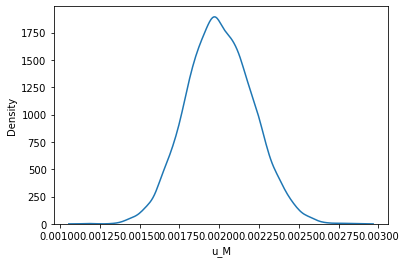

In [9]:
sns.kdeplot(data = df_post, x = "u_M")

In [10]:
x0 = torch.max(p_theta.mean - 4 * p_theta.stddev, lower).detach()
x1 = torch.min(p_theta.mean + 4 * p_theta.stddev, upper).detach()

print(x0)
print(x1)

num_pts = 1000
x = torch.from_numpy(np.linspace(x0, x1, num_pts))
pdf = torch.exp(p_theta.log_prob(x)).detach()

tensor([4.58894065e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.44800870e-05, 2.31079757e-05, 2.02386873e-05,
        5.00000000e+00, 5.00000000e+00, 5.00000000e+00])
tensor([3.24588595e-03, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.01448025e-03, 1.62310747e-03, 1.42023514e-03,
        4.05847702e+01, 4.05847702e+01, 4.05847702e+01])


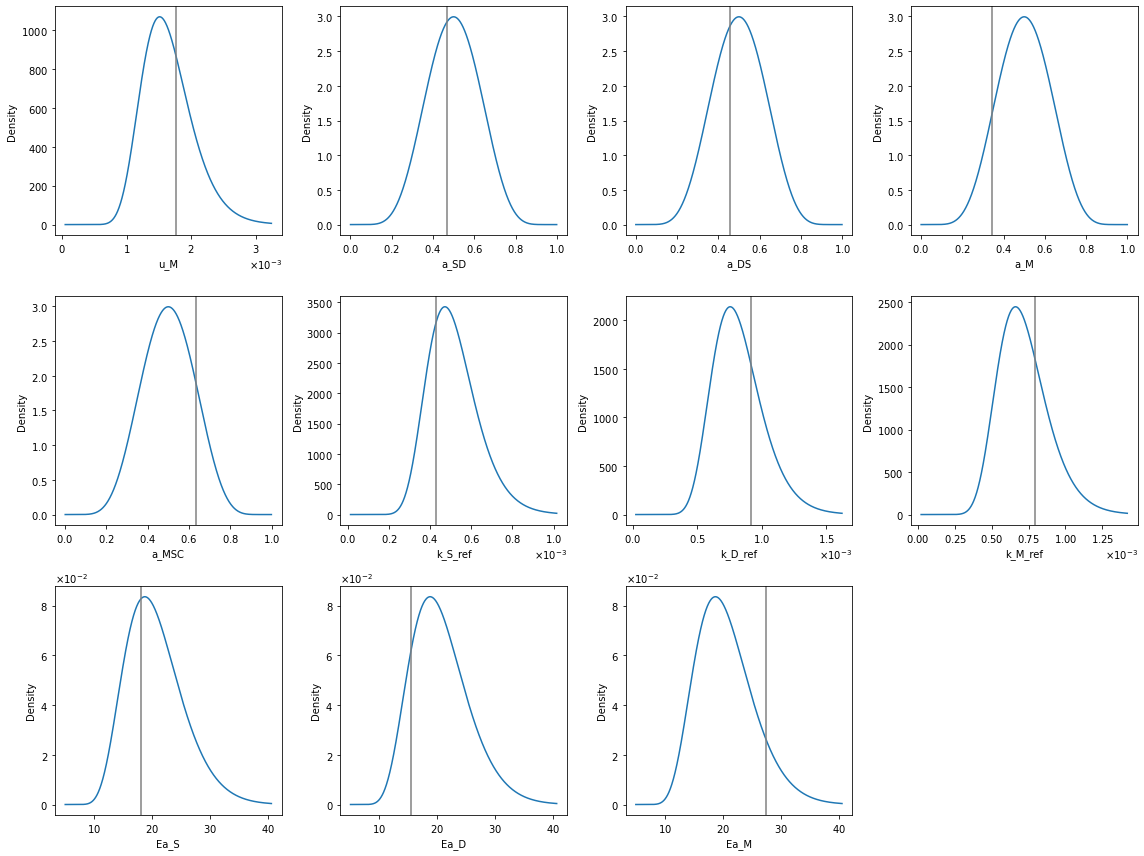

In [11]:
num_params = len(SCON_C_priors_details)
ncols = 4
nrows = int(num_params / ncols) + 1
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 4))
axes = np.atleast_2d(axes)
k = 0
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        if k < num_params:
            key = keys[k]
            ax.plot(x[:, k], pdf[:, k])
            ax.axvline(true_theta[key], color='gray')
            ax.set_xlabel(key)
            ax.set_ylabel('Density')
            ax.ticklabel_format(style='sci', scilimits=(-2,4), axis='both', useMathText='True')
        else:
            fig.delaxes(axes[i, j])
        k += 1  
plt.tight_layout()

In [12]:
#Create approximate posterior q_dist to facilitate plotting of posterior KDE densities.

#Parameter posterior summary means
u_M_mean = 0.00200
a_SD_mean = 0.437
a_DS_mean = 0.625
a_M_mean = 0.384
a_MSC_mean = 0.662
k_S_ref_mean = 0.000558
k_D_ref_mean = 0.00134
k_M_ref_mean = 0.000875
Ea_S_mean = 12.8
Ea_D_mean = 34.5
Ea_M_mean = 23.8

#Parameter posterior summary sds
u_M_sd = 2.10e-4
a_SD_sd = 1.89e-2
a_DS_sd = 2.08e-2
a_M_sd = 1.01e-1
a_MSC_sd = 1.28e-1
k_S_ref_sd = 1.73e-5
k_D_ref_sd = 1.49e-4
k_M_ref_sd = 1.12e-4
Ea_S_sd = 1.89
Ea_D_sd = 4.26
Ea_M_sd = 4.37

#SCON theta logit-normal distribution parameter details in order of mean, sdev, lower, and upper.
u_M_details = torch.Tensor([u_M_mean, u_M_sd, 0, 0.1])
a_SD_details = torch.Tensor([a_SD_mean, a_SD_sd, 0, 1])
a_DS_details = torch.Tensor([a_DS_mean, a_DS_sd, 0, 1])
a_M_details = torch.Tensor([a_M_mean, a_M_sd, 0, 1])
a_MSC_details = torch.Tensor([a_MSC_mean, a_MSC_sd, 0, 1])
k_S_ref_details = torch.Tensor([k_S_ref_mean, k_S_ref_sd, 0, 0.1])
k_D_ref_details = torch.Tensor([k_D_ref_mean, k_D_ref_sd, 0, 0.1])
k_M_ref_details = torch.Tensor([k_M_ref_mean, k_M_ref_sd, 0, 0.1])
Ea_S_details = torch.Tensor([Ea_S_mean, Ea_S_sd, 5, 80])
Ea_D_details = torch.Tensor([Ea_D_mean, Ea_D_sd, 5, 80])
Ea_M_details = torch.Tensor([Ea_M_mean, Ea_M_sd, 5, 80])

posteriors = {'u_M': u_M_details, 'a_SD': a_SD_details, 'a_DS': a_DS_details, 'a_M': a_M_details, 'a_MSC': a_MSC_details, 'k_S_ref': k_S_ref_details, 'k_D_ref': k_D_ref_details, 'k_M_ref': k_M_ref_details, 'Ea_S': Ea_S_details, 'Ea_D': Ea_D_details, 'Ea_M': Ea_M_details}

In [13]:
scale_lower = 1e-8 #Lower bound for scale search by bisect function.
scale_upper = 100 #Upper bound for scale search by bisect function. 

SCON_C_posteriors_dict = {}
for k, v in posteriors.items():
    sigmoid_loc, target_sd, a, b = v
    loc = logit(sigmoid_loc, a, b)
    scale = bisect(find_scale, scale_lower, scale_upper, (loc, a, b, target_sd))
    dist = RescaledLogitNormal(loc, scale, a, b)
    assert torch.abs(dist.stddev - target_sd) < 1e-4    
    
    SCON_C_posteriors_dict[k] = torch.tensor((loc, scale, a, b))

In [19]:
keys_post = list(SCON_C_posteriors_dict.keys())
loc_post, scale_post, a_post, b_post = torch.tensor(list(zip(*(SCON_C_posteriors_dict[k] for k in keys_post))))
print(loc_post, scale_post, a_post, b_post)
q_theta_NUTS = RescaledLogitNormal(loc_post, scale_post, a_post, b_post)

tensor([-3.89182019, -0.25334644,  0.51082563, -0.47260442,  0.67221969,
        -5.18297100, -4.29900980, -4.72991276, -2.15354943, -0.43332204,
        -1.09505999]) tensor([0.10633321, 0.07692277, 0.08888208, 0.44290143, 0.60230941, 0.03117005,
        0.11172789, 0.12763412, 0.26370373, 0.24082567, 0.31056774]) tensor([0., 0., 0., 0., 0., 0., 0., 0., 5., 5., 5.]) tensor([ 0.10000000,  1.00000000,  1.00000000,  1.00000000,  1.00000000,
         0.10000000,  0.10000000,  0.10000000, 80.00000000, 80.00000000,
        80.00000000])


In [20]:
x0 = torch.min(q_theta_NUTS.mean - 4 * q_theta_NUTS.stddev, p_theta.mean - 4 * p_theta.stddev)
x0 = torch.max(x0, lower).detach()

x1 = torch.max(q_theta_NUTS.mean + 4 * q_theta_NUTS.stddev, p_theta.mean + 4 * p_theta.stddev)
x1 = torch.min(x1, upper).detach()

print(x0)
print(x1)

num_pts = 10000
x = torch.from_numpy(np.linspace(x0, x1, num_pts))
pdf_prior = torch.exp(p_theta.log_prob(x)).detach()
pdf_post = torch.exp(q_theta_NUTS.log_prob(x)).detach()

tensor([4.58894065e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.44800870e-05, 2.31079757e-05, 2.02386873e-05,
        5.00000000e+00, 5.00000000e+00, 5.00000000e+00])
tensor([3.24588595e-03, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.01448025e-03, 1.94404577e-03, 1.42023514e-03,
        4.05847702e+01, 5.16477737e+01, 4.16088142e+01])


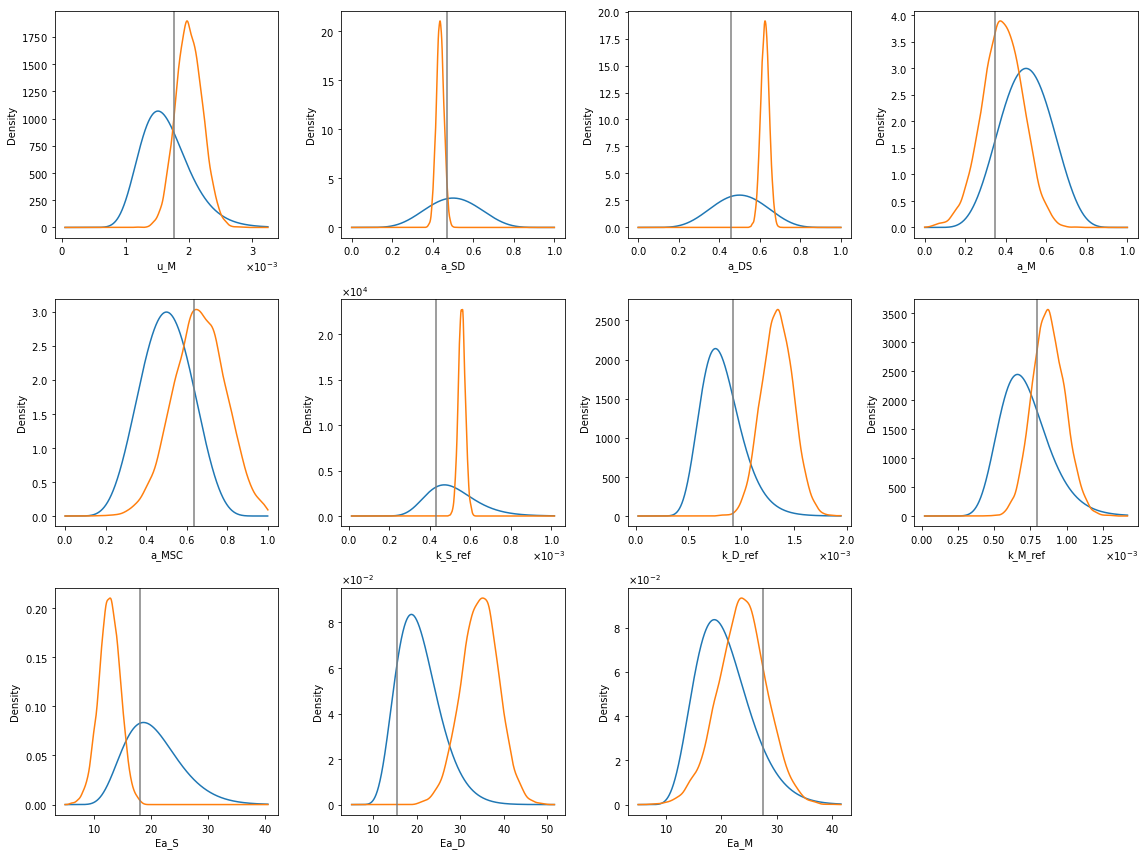

In [23]:
num_params = len(SCON_C_priors_details)
ncols = 4
nrows = int(num_params / ncols) + 1
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 4))
axes = np.atleast_2d(axes)
k = 0
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        if k < num_params:
            key = keys[k]
            post_kde_density = stats.gaussian_kde(df_post.loc[:, key])
            ax.plot(x[:, k], pdf_prior[:, k])
            ax.plot(x[:, k], post_kde_density(x[:, k]))
            ax.axvline(true_theta[key], color='gray')
            ax.set_xlabel(key)
            ax.set_ylabel('Density')
            ax.ticklabel_format(style='sci', scilimits=(-2,4), axis='both', useMathText='True')
        else:
            fig.delaxes(axes[i, j])
        k += 1  
plt.tight_layout()